In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

Цель работы - реализовать на PyTorch вариационный автокодировщик.

In [0]:
"""
Функции из utils.py
Делал сеть в colab, перенес их в ноутбук.
"""

mnist_transform = transforms.Compose([
                transforms.ToTensor(),               
               # transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [3]:
# Тренировка сети производилась на GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [0]:
# Создание загрузчиков данных.
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [0]:
# Задание параметров.
params = {"input_shape": 28*28, # Размер входа
          "layers_size": (500, 501), # Размеры полносвязных слоев
          "ld_size": 2, # Размер латентного слоя
          "classifier_layer_size": (64, 32), # Размеры слоев классификатора
          "num_classes": 10, # Количество классов в датасете
          "loss_fn": F.binary_cross_entropy, # Функция потерь для реконструкции
          "batch_size": 50}

Следующая ячейка содержит составные части вариационного автокодировщика. Encoder преобразует входные данные в скрытые измерения (размерностью ld_size), представляющие собой средние и ковариации многомерного нормального распределения. Для его обучения используется KL-divergence в качестве функции потерь. Этого нет в задании, но было очень интересно научиться как-то контролировать скрытые измерения, для этого добавлен модуль классификации, который учится сопоставлять входное изображение с меткой. Цель этого в том, что если класс цифры будет закодирован здесь, то латентные измерения кодировщика смогут содержать информацию о стиле. Decoder берет данные этих измерений вместе с вероятностями классов и реконструирует изображение.

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Создание слоев кодировщика.
        self.fc1 = nn.Linear(params["input_shape"], params["layers_size"][0])
        self.bn1 = nn.BatchNorm1d(params["layers_size"][0])
        self.fc2 = nn.Linear(params["layers_size"][0], params["layers_size"][1])
        self.bn2 = nn.BatchNorm1d(params["layers_size"][1])
        self.z_mean = nn.Linear(params["layers_size"][1], params["ld_size"])
        self.z_log_sigma_sq = nn.Linear(params["layers_size"][1], params["ld_size"])
    
    def forward(self, x):
        # Вычисление z_mean и z_log_sigma_sq.
        x = self.bn1(torch.sigmoid(self.fc1(x)))
        x = self.bn2(torch.sigmoid(self.fc2(x)))
        z_mean = self.z_mean(x)
        z_log_sigma_sq = self.z_log_sigma_sq(x)
        return z_mean, z_log_sigma_sq
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Создание слоев декодировщика.
        self.fc1 = nn.Linear(params["ld_size"] + params["num_classes"], params["layers_size"][0])
        self.bn1 = nn.BatchNorm1d(params["layers_size"][0])
        self.fc2 = nn.Linear(params["layers_size"][0], params["layers_size"][1])
        self.bn2 = nn.BatchNorm1d(params["layers_size"][1])
        self.fc3 = nn.Linear(params["layers_size"][1], params["input_shape"])
    
    def forward(self, x, probas):
        # Обединение z с вероятностями классов и реконструирование изображения.
        x = torch.cat([x, probas], 1)
        x = self.bn1(torch.sigmoid(self.fc1(x)))
        x = self.bn2(torch.sigmoid(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x
    
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # Создание слоев классификатора.
        self.fc1 = nn.Linear(params["input_shape"], params["classifier_layer_size"][0])
        self.bn1 = nn.BatchNorm1d(params["classifier_layer_size"][0])
        self.fc2 = nn.Linear(params["classifier_layer_size"][0], params["classifier_layer_size"][1])
        self.bn2 = nn.BatchNorm1d(params["classifier_layer_size"][1])
        self.fc3 = nn.Linear(params["classifier_layer_size"][1], 10)        
    
    def forward(self, x):
        # Вычисление logits для функции ошибки и probas для декодировщика.
        x = self.bn1(torch.sigmoid(self.fc1(x)))
        x = self.bn2(torch.sigmoid(self.fc2(x)))
        logits = self.fc3(x)
        probas = nn.Softmax(-1)(logits)
        return logits, probas

In [0]:
class Net(nn.Module):
    def __init__(self, lr=1e-3, l2=0.):
        super(Net, self).__init__()
        # Создание автокодировщика
        self.input_shape = params["input_shape"]
        self.ld_size = params["ld_size"]
        self.encoder = Encoder()        
        self.decoder = Decoder()        
        self.classifier = Classifier()
        self.z_mean = None
        self.z_log_sigma_sq = None
        self.loss_fn = params["loss_fn"]
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        # Преобразование размерностей
        x = x.view(-1, self.input_shape)
        # Получение выхода кодировщика
        z_mean, z_log_sigma_sq = self.encoder(x)
        # Репараметризация
        eps = torch.randn(params["batch_size"], params["ld_size"]).to(device)
        z = z_mean + torch.mul(torch.sqrt(torch.exp(z_log_sigma_sq)), eps)
        # Получение выхода классификатора
        logits, probas = self.classifier(x)
        # Реконструирование изображения
        d = self.decoder(z, probas)        
        return d, z_mean, z_log_sigma_sq, z, logits    
    
    def loss(self, x, target, **kwargs):
        # Функция потерь реконструкции (задана в параметрах)
        target = target.view(-1, self.input_shape)        
        reconstr_loss = self.loss_fn(x, target, reduction='sum')
        # Эксперементировал с весами для каждого вида ошибок, поскольку они "конкурируют" друг с другом
        # при обучении. Оставленные показали лучший результат.
        self._loss = 0.2*reconstr_loss
        return self._loss
    
    def latent_loss(self, z_mean, z_log_sigma_sq, **kwargs):
        # Функция потерь скрытого слоя (KL-divergence для многомерного стандартного нормального распределения).
        latent_loss = -0.5 * torch.sum(1 + z_log_sigma_sq - z_mean.pow(2) - z_log_sigma_sq.exp())
        return latent_loss
    
    def classifier_loss(self, x, target, **kwargs):
        # Функция потерь классификатора.
        classifier_loss = 1000*F.cross_entropy(x, target, **kwargs)
        return classifier_loss

In [0]:
# Создание модели.
model_ae = Net()
model_ae.to(device)
train_log = []
test_log = []

In [0]:
# Train и test функции взяты из лекций с небольшими модификациями.
def train(epoch, model, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        model.optim.zero_grad()
        output, m, s, _, logits = model(data)        
        reconstruction_loss = model.loss(output, data)
        latent_loss = model.latent_loss(m, s)
        classifier_loss = model.classifier_loss(logits, target)
        loss = reconstruction_loss + latent_loss + classifier_loss
        loss.backward()
        model.optim.step()
        
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = '{:.6f}'.format(loss.item()/len(data))
            print(line + losses)
            
    batch_idx += 1
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = '{:.6f}'.format(loss.item()/len(data))
    if log is not None:
        log.append([loss.item()/len(data), reconstruction_loss.item()/len(data), latent_loss.item()/len(data), classifier_loss.item()/len(data)])
    print(line + losses)

In [0]:
avg_lambda = lambda l, ll, lc: 'reconstruction loss: {:.4f}, latent loss {:.4f}, classifier loss {:.4f}'.format(l, ll, lc)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)

def test(model, loader, log=None):
    test_size = len(loader.sampler)
    test_reconstruction_loss = 0.
    test_latent_loss = 0.
    test_classifier_loss = 0.
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output, m, s, _, logits = model(data)            
            test_reconstruction_loss += model.loss(output, data).item() # sum up batch loss
            test_latent_loss += model.latent_loss(m, s).item() # sum up batch loss
            test_classifier_loss += model.classifier_loss(logits, target).item() # sum up batch loss
            
    test_reconstruction_loss /= (test_size)
    test_latent_loss /= (test_size)
    test_classifier_loss /= test_size
    if log is not None:
        log.append([test_reconstruction_loss+test_latent_loss + test_classifier_loss, test_reconstruction_loss, test_latent_loss, test_classifier_loss])
        
    lines = '\n' + avg_lambda(test_reconstruction_loss, test_latent_loss, test_classifier_loss) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [11]:
# Обучение модели в течение 25 эпох.
for epoch in range(1, 26):
    model_ae.train()
    train(epoch, model_ae, train_log)
    model_ae.eval()
    test(model_ae, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 156.398340
Train Epoch: 1 [10000/50000 (20%)]	Losses 43.569927
Train Epoch: 1 [20000/50000 (40%)]	Losses 39.936677
Train Epoch: 1 [30000/50000 (60%)]	Losses 39.566060
Train Epoch: 1 [40000/50000 (80%)]	Losses 33.132810
Train Epoch: 1 [50000/50000 (100%)]	Losses 33.692622
Test set:

reconstruction loss: 27.9336, latent loss 1.9740, classifier loss 5.1868

Train Epoch: 2 [0/50000 (0%)]	Losses 33.437341
Train Epoch: 2 [10000/50000 (20%)]	Losses 39.966172
Train Epoch: 2 [20000/50000 (40%)]	Losses 33.053618
Train Epoch: 2 [30000/50000 (60%)]	Losses 31.146052
Train Epoch: 2 [40000/50000 (80%)]	Losses 31.418350
Train Epoch: 2 [50000/50000 (100%)]	Losses 38.190425
Test set:

reconstruction loss: 27.1825, latent loss 2.2523, classifier loss 3.3944

Train Epoch: 3 [0/50000 (0%)]	Losses 32.154556
Train Epoch: 3 [10000/50000 (20%)]	Losses 34.050330
Train Epoch: 3 [20000/50000 (40%)]	Losses 33.318005
Train Epoch: 3 [30000/50000 (60%)]	Losses 33.074155
Train Epoc

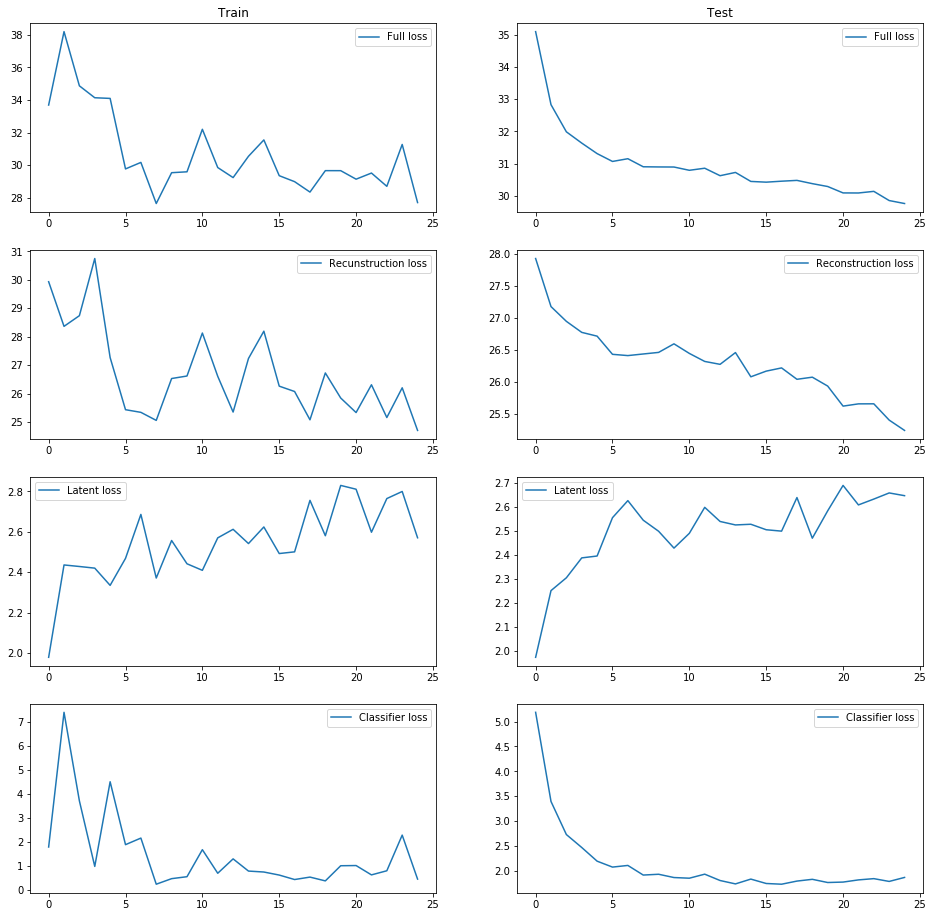

In [12]:
# Отрисовка графиков ошибок.
plt.figure(figsize=(16, 16))
plt.subplot(4, 2, 1)
plt.plot(np.array(train_log)[:,0], label="Full loss")
plt.title("Train")
plt.legend()
plt.subplot(4, 2, 2)
plt.plot(np.array(test_log)[:,0], label="Full loss")
plt.title("Test")
plt.legend()
plt.subplot(4, 2, 3)
plt.plot(np.array(train_log)[:,1], label="Recunstruction loss")
plt.legend()
plt.subplot(4, 2, 4)
plt.plot(np.array(test_log)[:,1], label="Reconstruction loss")
plt.legend()
plt.subplot(4, 2, 5)
plt.plot(np.array(train_log)[:,2], label="Latent loss")
plt.legend()
plt.subplot(4, 2, 6)
plt.plot(np.array(test_log)[:,2], label="Latent loss")
plt.legend()
plt.subplot(4, 2, 7)
plt.plot(np.array(train_log)[:,3], label="Classifier loss")
plt.legend()
plt.subplot(4, 2, 8)
plt.plot(np.array(test_log)[:,3], label="Classifier loss")
plt.legend()

plt.show()

На графиках видна отрицательная корреляция между ошибкой скрытого слоя и двумя другими. Изменяя веса разных ошибок можно добиться снижения KL, но тогда какая-нибудь другая ведет себя хуже. Такой вариант показался наиболее интересным, поскольку, в случаях, когда latent_loss снижался почти до нуля, терялась вся информация о почерке.

In [0]:
# Генерация изображений по входным и по сэмплу нормального распределения.
data, _ = next(iter(test_loader))
data = data.to(device)
output, _, _, _, _ = model_ae(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = model_ae.decoder(torch.randn(params["num_classes"], params["ld_size"]).to(device), torch.eye(params["num_classes"]).to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

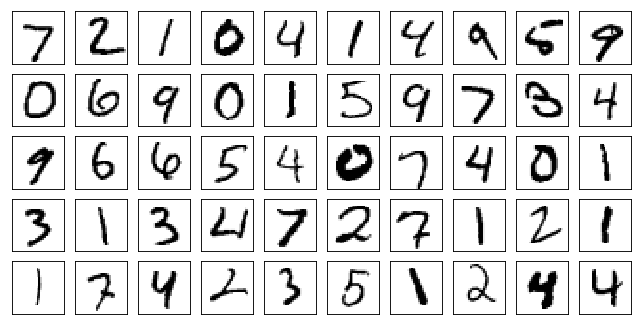

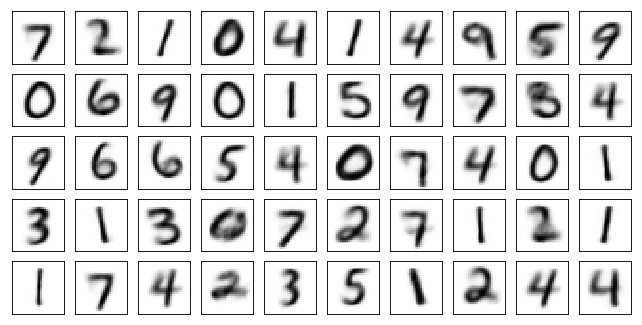

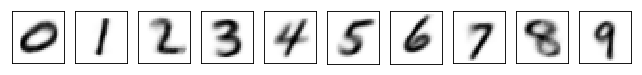

In [14]:
# Вывод сгенерированных картинок. Все цифры различимы, впечатление, что созданные из сэмпла выглядят лучше.
plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(dec_to_plot, (1, 10))

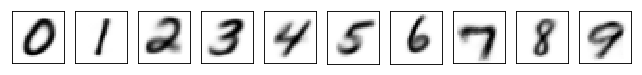

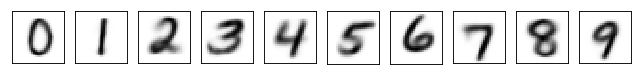

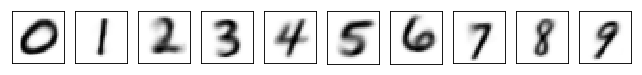

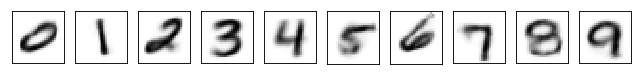

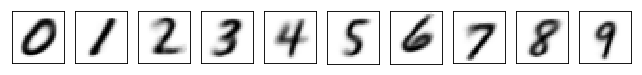

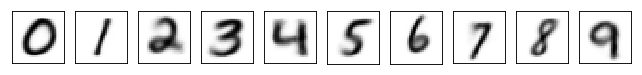

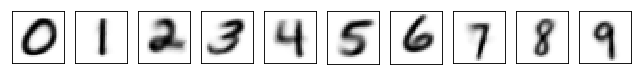

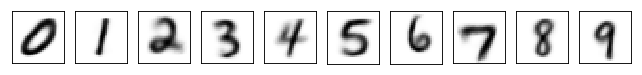

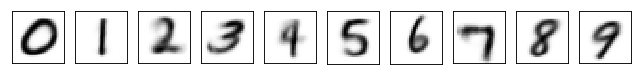

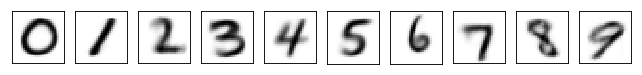

In [15]:
"""
Генерация изображений с явно заданным классом. Например, если передать в Decoder вероятности 
[0,0,0,0,0,0,0,0,0,1], то будут выводиться девятки. В латентный слой передается сэмпл из нормального
распределения, поэтому можно видеть различия в стиле каждой цифры.
"""
for i in range(10):    
    decoded = model_ae.decoder(torch.randn(params["num_classes"], params["ld_size"]).to(device), torch.eye(params["num_classes"]).to(device))
    dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
    plot_mnist(dec_to_plot, (1, 10))

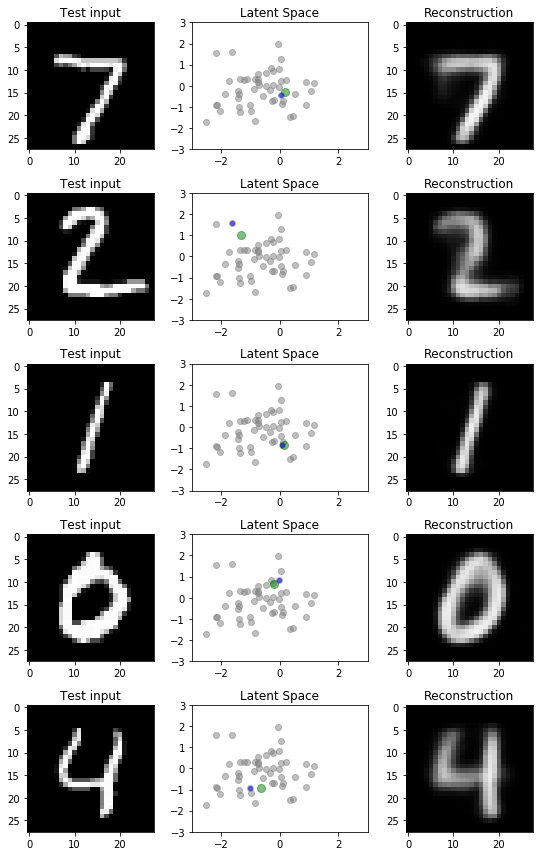

In [16]:
# Вывод изображений и их места в скрытом пространстве (как в лекции).
data, _ = next(iter(test_loader))
data = data.to(device)
output, m, s, z, _ = model_ae(data)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(data[i].cpu().reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
    plt.title("Test input")
        
    plt.subplot(5, 3, 3*i + 2)
    plt.scatter(z.cpu().detach()[:,0],z.cpu().detach()[:,1], c='gray', alpha=0.5)
    plt.scatter(m.cpu().detach()[i,0],m.cpu().detach()[i,1], c='green', s=64, alpha=0.5)
    plt.scatter(z.cpu().detach()[i,0],z.cpu().detach()[i,1], c='blue', s=16, alpha=0.5)
       
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.title("Latent Space")
        
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(output.cpu().detach()[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
    plt.title("Reconstruction")
        
    plt.tight_layout()

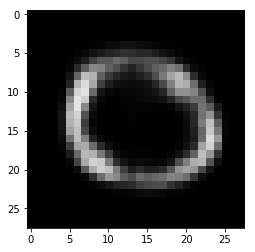

In [18]:
# Генерация изображения из определенной точки в скрытом пространстве (тоже из лекции)
d = np.zeros([1,params["ld_size"]],dtype='float32')
d[0, :2] = [-2,-3]
x_reconstruct = model_ae.decoder(torch.Tensor(d).to(device), torch.eye(params["num_classes"])[[0]].to(device))
plt.imshow(x_reconstruct.cpu().detach()[0].reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))

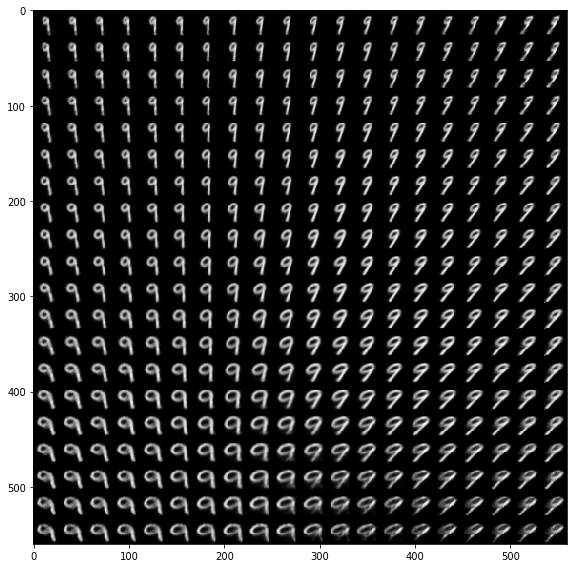

In [19]:
"""
Создание карты изображений по скрытому пространству. Поскольку класс цифры задается в пространстве вероятностей,
то здесь остается информация о стиле. Например, в данном случае были отрисованы выученные варианты почерка
при написании девяток.
"""
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        d = np.zeros([1,params["ld_size"]],dtype='float32')
        z_mu = np.array([[xi, yi]])
        d[0,:2] = z_mu        
        x_mean = model_ae.decoder(torch.Tensor(d).to(device), torch.eye(params["num_classes"])[[9]].to(device))
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean.cpu().detach()[0].reshape(28, 28)

plt.figure(figsize=(8, 8))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()